<h1> Lab 4 </h1> 
<br>
<h2> Brooking around </h2> <br>
Burning down forests and all that

The boiler plate

In [156]:
import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

#For Making a Sandbox
from numpy.random import uniform
from numpy import multiply
from scipy.ndimage.filters import gaussian_filter

Carson's Basic DEM

In [157]:
#The DEMbox
def surface(dim=(100,100), low=100, high=4500, sigma=3):
    '''Super basic random terrain function.
    
    This function generates a uniform random surface,
    and applies a sequence (x and y) of one-dimensional
    convolution filters; effectively increasing the spatial
    autocorrelation of the surface relative to sigma.
    
    Paramters
    ---------
    dim : tuple
        The x and y dimensions of the 'terrain' grid.
    low : numeric
        The lowest possible simulated elevation value.
    high : numeric
        The highest possible simulated elevation value.
    sigma : numeric
        The variance of the gaussian kernel. Controls
        the 'smoothness' of the simulated surface.
        Values between 1 and 3 are probably good for
        'small' surfaces.
        
    Returns
    -------
    out : ndarray
        A spatially autocorrelated random 'terrain' surface
        of a given dimension.
    '''
    r = uniform(low, high, size=multiply(*dim)).reshape(dim)
    return gaussian_filter(r, sigma=sigma, truncate=9)

To model wind, I found a package called windrose which helps with plotting wind speed and wind direction

In [158]:
#ModelingWind

from windrose import WindroseAxes

import matplotlib.cm as cm

Just sampling some of the package visualizations

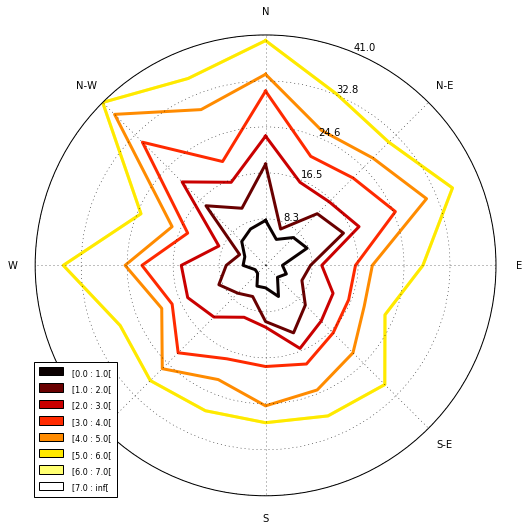

In [159]:
import pandas as pd
from windrose import plot_windrose
N = 500
ws = np.random.random(N) * 6
wd = np.random.random(N) * 360
dfwind = pd.DataFrame({'speed': ws, 'direction': wd})
plot_windrose(dfwind, kind='contour', bins=np.arange(0.01,8,1), cmap=cm.hot, lw=3)

This is the base forest code from projectmesa's forest fire example. I added something in the loop that would make it so that trees at a lower elevation would catch fire, and the trees at a higher elevation wouldn't because magic. Completely arbitrary and elevation elitist magic. <br><br> Apparently, that yields basically no trees on fire, so I reversed it to only burn upward. Now it's elevation discriminatory arbitrary  magic. <br> Back again with more ideas to make the magic arbitrary and elitist.

In [160]:
#TheForest
class TreeCell(Agent):
    '''
    A tree cell. YAY TREES.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        self.elevation = model.DEM[pos[1]][pos[0]]
        self.wind = self.dfwind 
        
    def current_step(self):
        return self.model.schedule.steps
    
    def wind_speed(self):
        N = 500
            ws = np.random.random(N) * 6
            wd = np.random.random(N) * 360
            dfwind = pd.DataFrame({'speed': ws, 'direction': wd})
        return self.model.wind.speed[self.current_step()]
    
    def firescore(self, neighbor):
        return (self.wind_speed() * .5) + ((neighbor.elevation - self.elevation) * .5)
    
    def fiyahmakah(self):
        min_wind = self.model.wind.speed_min
        max_wind = self.model.wind.speed_max
        min_elevation = 100
        max_elevation = 3000
        return np.average(((min_wind *.7) + ((min_elevation - max_elevation) *.3), (max_wind * .7) + ((max_elevation - min_elevation)*.3)))
    
    def get_condition(self, neighbor):
        if self.firescore(neighbor) >= self.fiyahmakah():
            return "On Fire"
        else:
            return "Fine"  
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                    if neighbor.condition == "Fine":
                        if neighbor.elevation  >2500:
                            neighbor.condition = "Fine"
                    if neighbor.elevation <= self.elevation:
                        neighbor.condition = "On Fire"
            self.condition = "Burned Out"

My thinking for the next bit wanted to see that my fire score was impacted by brush density and wind speed. Adding a brush density is apparently a lot harder than I thought, when really it should just be another weighted category but I can't seem to get it right. <br> The logic was: Hopefully, where there is a higher brush density, the likelihood of catching fire compounded with wind direction will make it so that a neighboring tree is going to catch fire, like real life almost. <br> However, since I can't get that simple thing to function, I'm going to just keep trying to make the wind speed/direction relevant. 

In [161]:
#TheFire
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    #DEM Magic Goes Here?
    
    DEM = surface(dim=(100,100), low=100, high=3000, sigma=2)
    
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
     
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        self.DEM = self.DEM
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)

        self.running = True
        
   
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

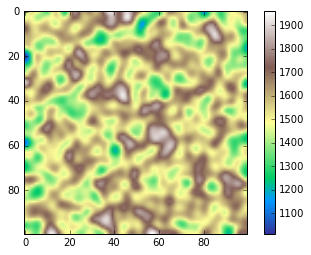

In [162]:
from matplotlib import animation
plt.imshow(ForestFire.DEM, cmap=plt.get_cmap("terrain"))
plt.colorbar()
plt.show()

In [163]:
fire = ForestFire(100, 100, 0.8)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()

AttributeError: 'TreeCell' object has no attribute 'dfwind'

In [ ]:
param_set = dict(height=50, # Height and width are constant
                 width=50,
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 density=np.linspace(0,1,101)[1:])

In [ ]:
# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / 
                                          m.schedule.get_agent_count()) }

In [ ]:
param_run = BatchRunner(ForestFire, param_set, model_reporters=model_reporter)

In [ ]:
param_run.run_all()

In [ ]:
df = param_run.get_model_vars_dataframe()

In [ ]:
df.head()

In [ ]:
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

In [ ]:
param_run = BatchRunner(ForestFire, param_set, iterations=5, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

I'm really just looking for a way to animate this.

In [ ]:
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()